In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier as MLP
rand_state = 2022
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from util import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('data/stroke.csv').rename(columns={'stroke':'y'})
df_raw.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,y
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
df_raw['y'].value_counts()

0    4733
1     248
Name: y, dtype: int64

In [4]:
data = preprocess(df_raw
                  , cat_cols = ['gender','ever_married','work_type','Residence_type','smoking_status']
                  , num_cols = ['age','avg_glucose_level','bmi'])

In [5]:
X = data.drop(columns=['y'])
y = data['y']
ori_cols = X.columns

# Cluster

## K-means

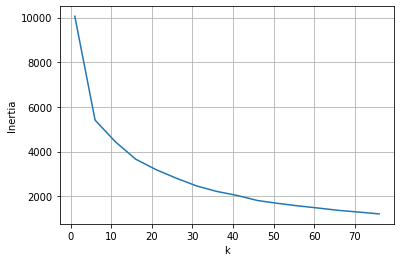

In [6]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [7]:
k = 2
k_means = KMeans(n_clusters=k, random_state=rand_state)
k_means.fit(X)
stat, p, dof, expected = chi2_contingency(pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                                                     ,axis=1).groupby(['y','k_means_label'], as_index=False).count().pivot(index='y',columns='k_means_label',values='index').fillna(0).values)
print(p)
contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                                                     ,axis=1).groupby(['y','k_means_label'], as_index=False).count().pivot(index='y',columns='k_means_label',values='index').fillna(0)
print(contigency_matrix)

1.8908888919924468e-16
k_means_label     0     1
y                        
0              3063  1670
1               224    24


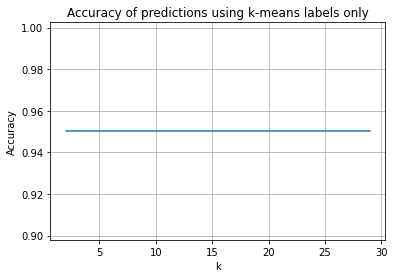

In [8]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

## Expectation Maximization

In [9]:
from sklearn.mixture import GaussianMixture

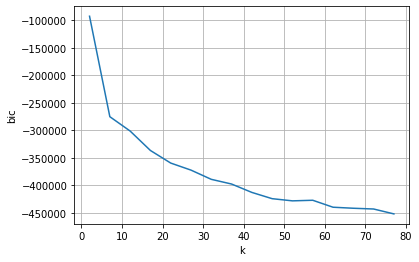

In [10]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X)
    res.append(gmm.bic(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

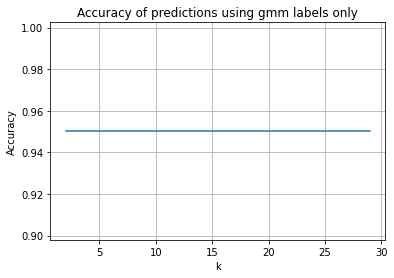

In [11]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

# Dimensionality Reduction

## PCA

In [12]:
from sklearn.decomposition import FastICA, PCA,TruncatedSVD
from numpy.linalg import eig

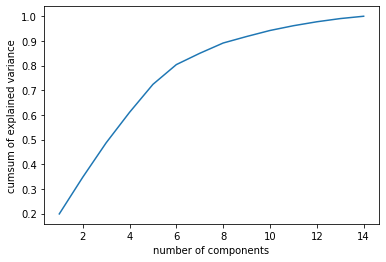

In [13]:
pca = PCA().fit(X)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumsum of explained variance')
plt.show()

In [14]:
eig(pca.get_covariance())

(array([0.40144283, 0.29991386, 0.28195927, 0.24973003, 0.22920623,
        0.16172592, 0.09252352, 0.08418514, 0.01912532, 0.02612941,
        0.0323169 , 0.05311028, 0.04951817, 0.03890932]),
 array([[-3.11734967e-01, -2.23153727e-01,  4.54219744e-02,
         -3.23088434e-02,  1.92609871e-02,  4.51082804e-03,
          9.21921694e-02,  6.28156578e-02, -6.54564827e-01,
         -5.40129348e-01, -2.67468322e-01,  2.12213188e-01,
          1.75869068e-02,  1.51834660e-03],
        [-1.00470451e-01, -9.67757643e-02,  3.90615981e-02,
         -2.93613510e-02,  4.59282983e-02, -1.86742880e-02,
          3.60581516e-01,  8.52403277e-01,  1.00005100e-01,
          3.23087858e-02,  7.45585868e-03, -2.83118748e-01,
          1.10843792e-01, -1.24662299e-01],
        [-4.62994840e-02, -7.42368621e-02, -1.72593287e-02,
         -2.33409740e-02,  3.87750870e-02, -1.13315791e-02,
          1.12878209e-01,  1.37132272e-01,  1.47305564e-01,
          2.40029749e-01,  1.09538314e-02,  8.46396565e-01

### pca + k-means

In [15]:
X0 = PCA(2).fit_transform(X)

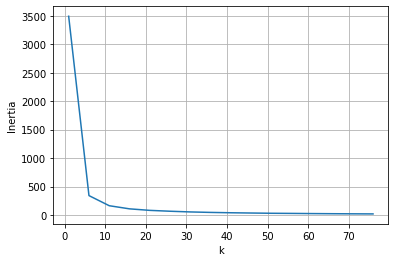

In [16]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

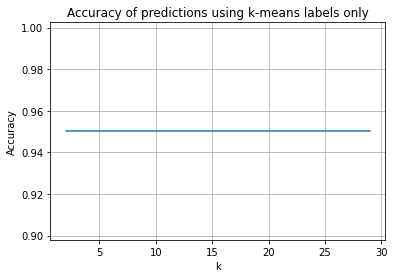

In [17]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### PCA + EM

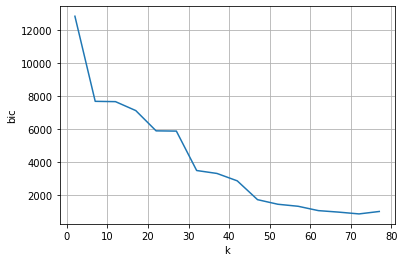

In [18]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

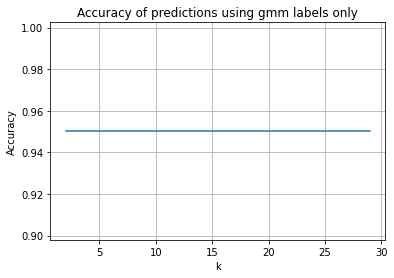

In [19]:
ks = range(2,30,1)
res = []
X0 = PCA(2).fit_transform(X)
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

## ICA

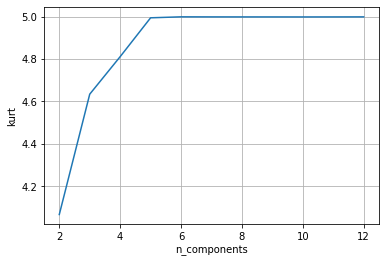

In [20]:
res = []
ks = range(2,13,1)
for k in ks:
    ica = FastICA(n_components = k, random_state=rand_state)
    tmp_df = pd.DataFrame(ica.fit_transform(X))
    #res.append(tmp_df.kurt(axis=0).abs().mean())
    res.append(abs(np.min(tmp_df.kurt(axis=0) -3)))
plt.plot(ks,res)
plt.xlabel('n_components')
plt.ylabel('kurt')
plt.grid()
plt.show()

### ica + k-means

In [21]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)

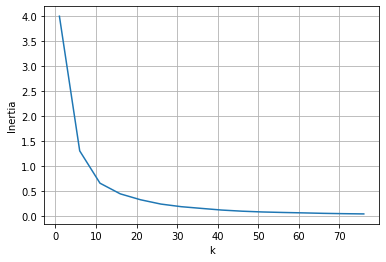

In [22]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

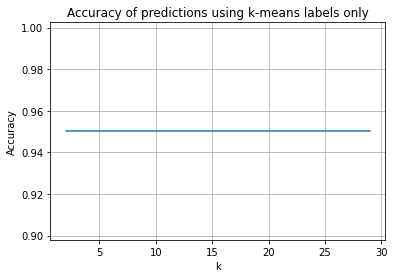

In [23]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### ica+EM

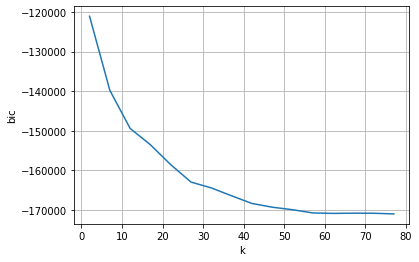

In [24]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

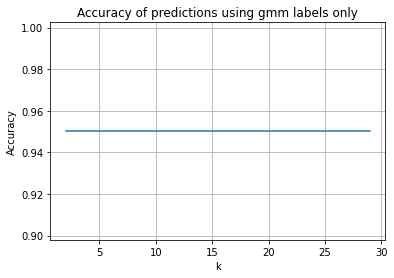

In [25]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

## Randomized Projections

In [26]:
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

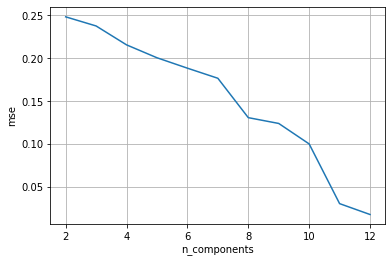

In [27]:
res = []
ks = range(2,13,1)
for k in ks:
    grp = GaussianRandomProjection(n_components = k, random_state=rand_state)
    X1 = grp.fit_transform(X)
    X_hat = X1.dot(np.linalg.pinv(grp.components_.T))
    res.append(metrics.mean_squared_error(X, X_hat))
plt.plot(ks,res)
plt.xlabel('n_components')
plt.ylabel('mse')
plt.grid()
plt.show()

### GRP + k-means

In [28]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)

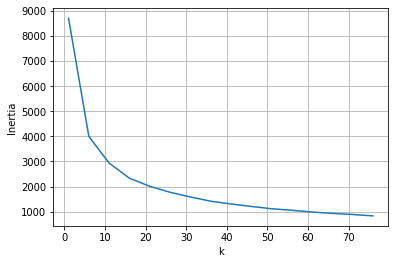

In [29]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

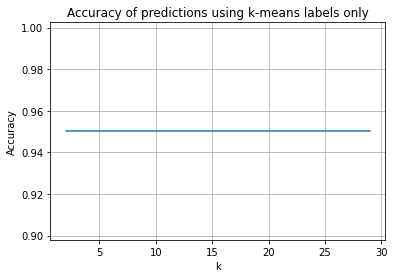

In [30]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### grp + em

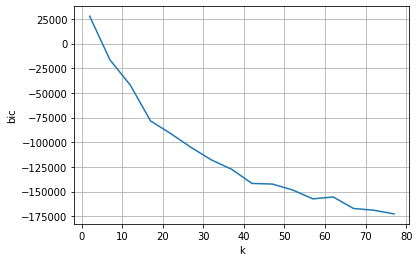

In [31]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

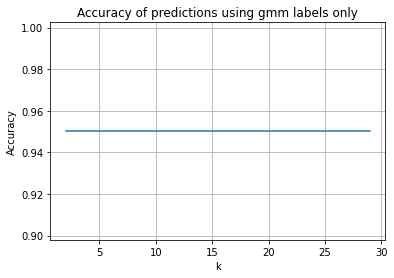

In [32]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

## svd 

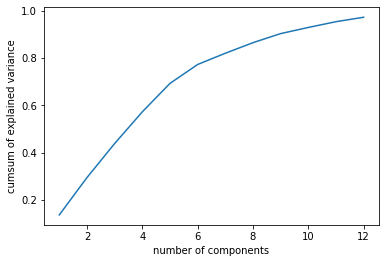

In [33]:
svd = TruncatedSVD(12).fit(X)
plt.plot(range(1, len(svd.explained_variance_ratio_) + 1), np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumsum of explained variance')
plt.show()

### svd + k-means

In [34]:
X0 = TruncatedSVD(2).fit_transform(X)

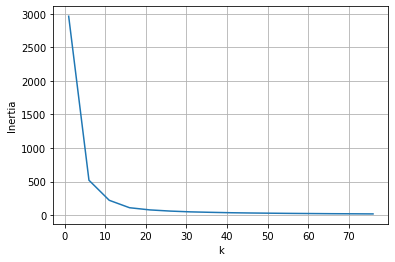

In [35]:
ks = range(1,80,5)

res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    k_means.fit(X0)
    res.append(k_means.inertia_)
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()
plt.show()

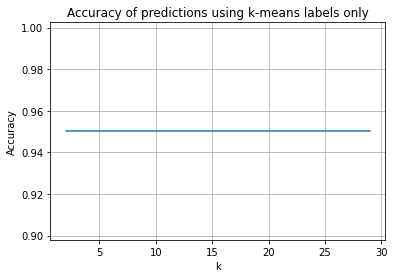

In [36]:
ks = range(2,30,1)
res = []
for k in ks:
    k_means = KMeans(n_clusters=k, random_state=rand_state)
    
    k_means.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(k_means.labels_,columns=['k_means_label']).reset_index(),y]
                       ,axis=1).groupby(['y','k_means_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='k_means_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using k-means labels only')
plt.grid()
plt.show()

### svd + em

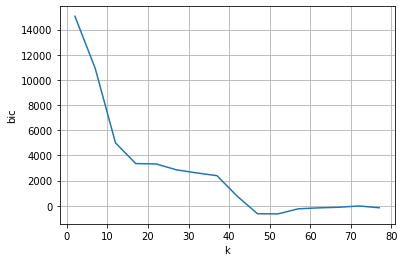

In [37]:
ks = range(2,80,5)

res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    res.append(gmm.bic(X0))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('bic')
plt.grid()
plt.show()

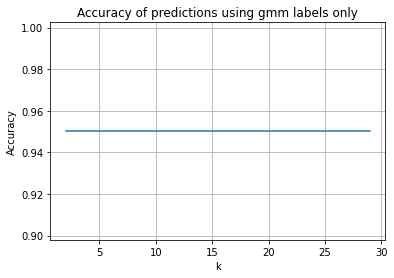

In [38]:
ks = range(2,30,1)
res = []
for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=rand_state)
    gmm.fit(X0)
    contigency_matrix = pd.concat([pd.DataFrame(gmm.predict(X0),columns=['gmm_label']).reset_index(),y]
                       ,axis=1).groupby(['y','gmm_label']
                                        , as_index=False).count().pivot(index='y'
                                                                        ,columns='gmm_label'
                                                                        ,values='index').fillna(0)
    res.append(contigency_matrix.max(axis=0).sum()/len(X))
plt.plot(ks,res)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of predictions using gmm labels only')
plt.grid()
plt.show()

In [39]:
data

,age,hypertension,heart_disease,avg_glucose_level,bmi,y,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0,1,0.801265,0.647564,1,1,1,1,0,0,1,1,0,0
1,0.975586,0,1,0.234512,0.530086,1,1,1,1,0,0,0,0,1,0
2,0.597168,0,0,0.536008,0.584527,1,0,1,1,0,0,1,0,0,1
3,0.963379,1,0,0.549349,0.286533,1,0,1,0,1,0,0,0,1,0
4,0.987793,0,0,0.605161,0.429799,1,1,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,0.499512,0,0,0.069384,0.452722,0,1,0,1,0,0,0,1,0,0
4977,0.487305,0,0,0.627966,0.489971,0,1,1,1,0,0,1,0,0,1
4978,0.548340,1,0,0.184194,0.510029,0,0,1,0,0,0,0,0,0,1
4979,0.487305,0,0,0.133044,0.458453,0,1,1,1,0,0,0,0,0,1


## dr + NN 

### pca + NN

train roc_auc score: [0.74392697 0.76002854 0.76178293 0.76554218 0.7656473 ]
test roc_auc score: [0.73864746 0.7524892  0.7570046  0.76104755 0.75958173]


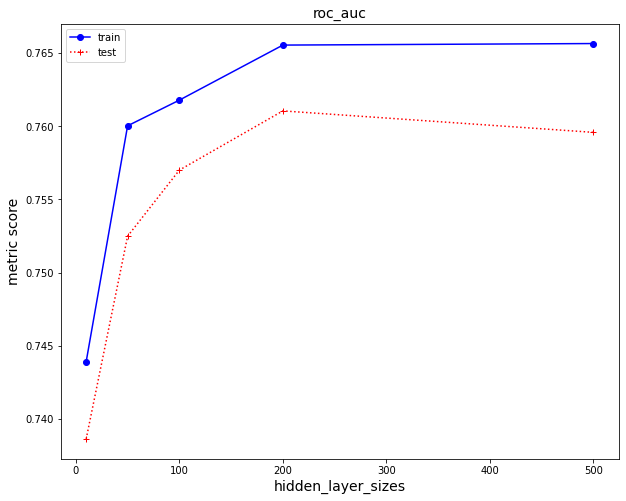

train neg_log_loss score: [-0.17967856 -0.17686592 -0.17679863 -0.17578338 -0.17563268]
test neg_log_loss score: [-0.18081904 -0.17907936 -0.17872149 -0.17764307 -0.17787506]


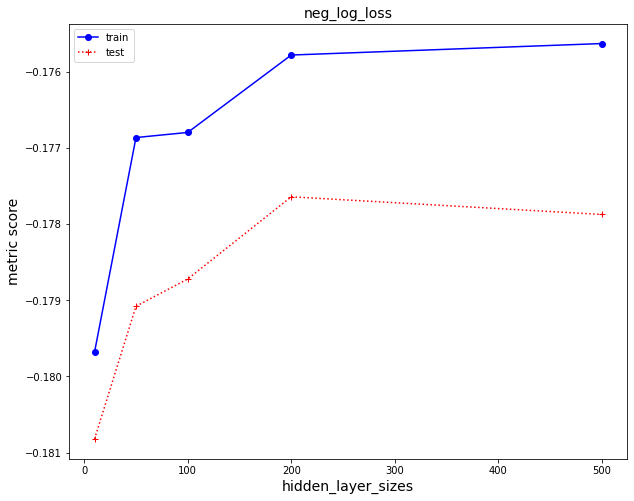

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


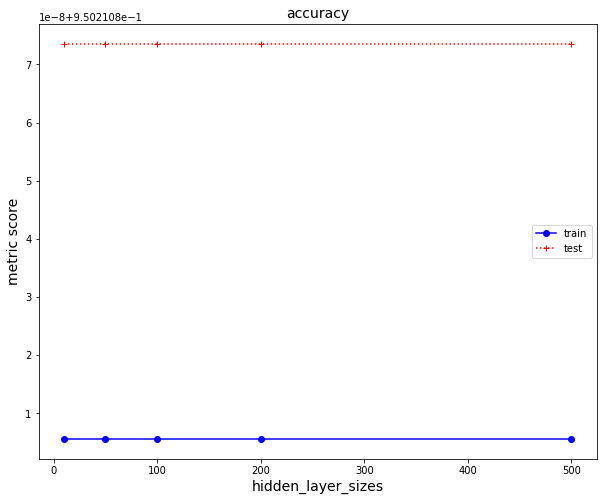

mean fit time: [0.46147623 0.56635423 0.69630213 1.45020471 2.36083913]


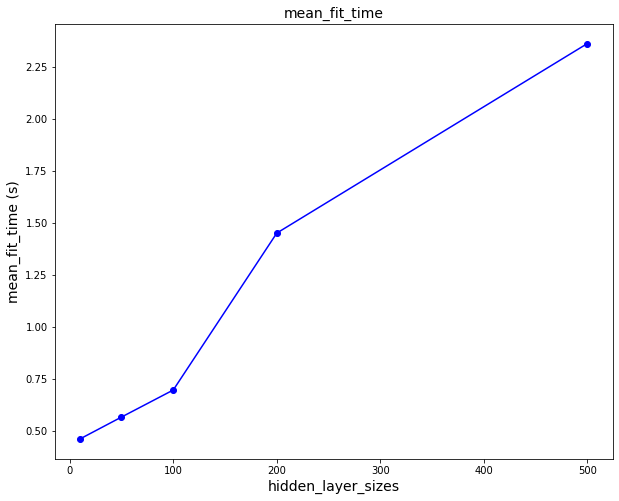

In [40]:
X0 = PCA(2).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

train roc_auc score: [0.78651775 0.83539922 0.86099639 0.87053865 0.8805785 ]
test roc_auc score: [0.76546677 0.77183355 0.77465373 0.77641563 0.76973003]


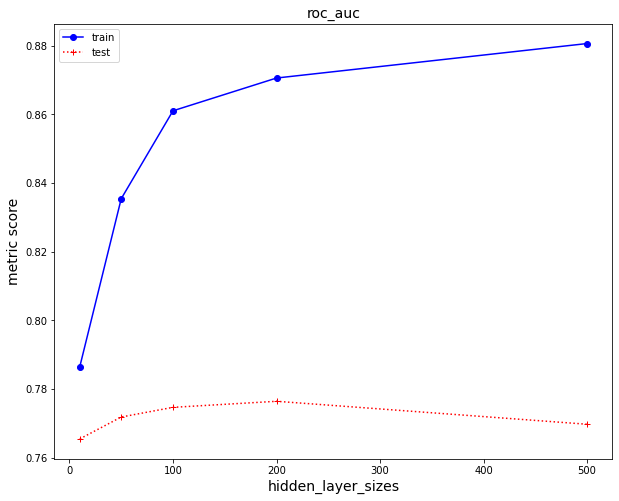

train neg_log_loss score: [-0.17250291 -0.15943351 -0.15100147 -0.14747402 -0.14392073]
test neg_log_loss score: [-0.17828994 -0.17817612 -0.17936441 -0.17989456 -0.18415802]


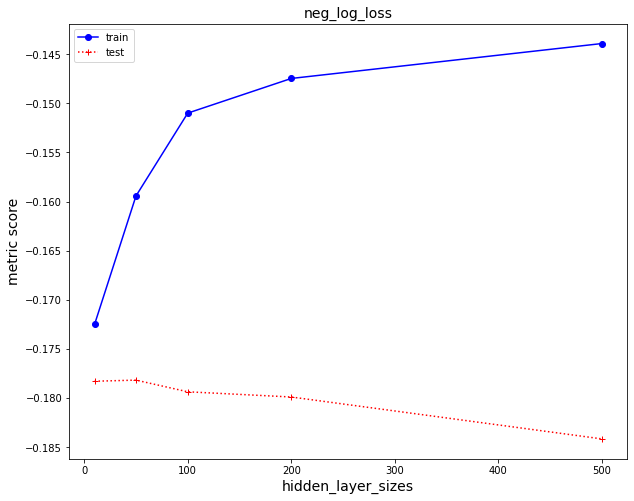

train accuracy score: [0.95021081 0.95076293 0.95151576 0.95181688 0.95216821]
test accuracy score: [0.95021087 0.95021087 0.95001007 0.94960867 0.94860445]


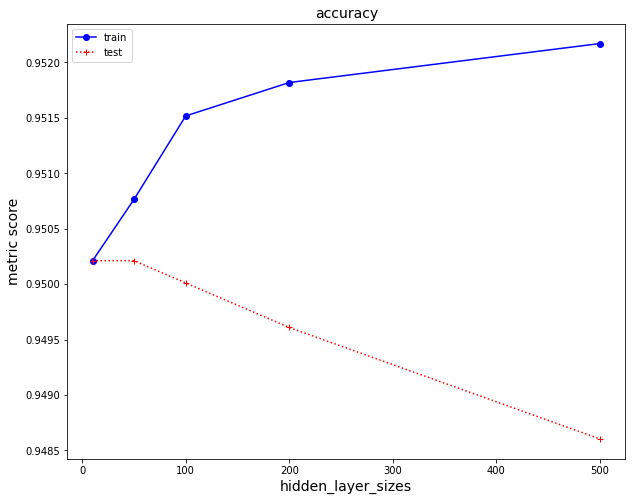

mean fit time: [ 0.5461246   1.93057294  3.42401028  5.39106812 10.07442055]


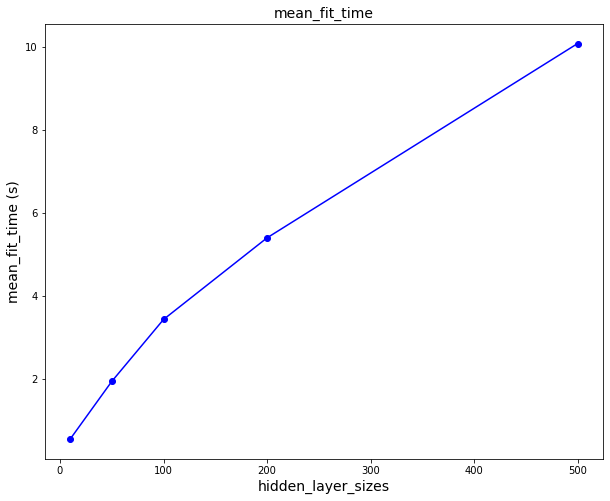

In [41]:
X0 = PCA(8).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### ica+NN

train roc_auc score: [0.71886678 0.73287764 0.74670108 0.74961464 0.7532053 ]
test roc_auc score: [0.70491525 0.72117416 0.7371933  0.74066085 0.74453884]


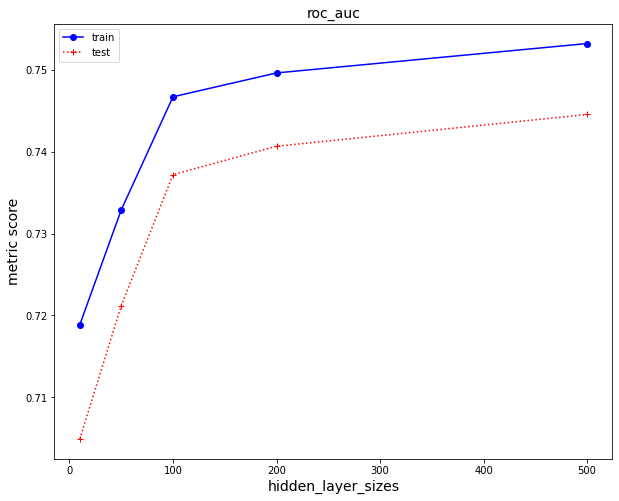

train neg_log_loss score: [-0.19600754 -0.19435453 -0.18041873 -0.17981197 -0.17940448]
test neg_log_loss score: [-0.19623986 -0.19459189 -0.18191856 -0.18146826 -0.18084896]


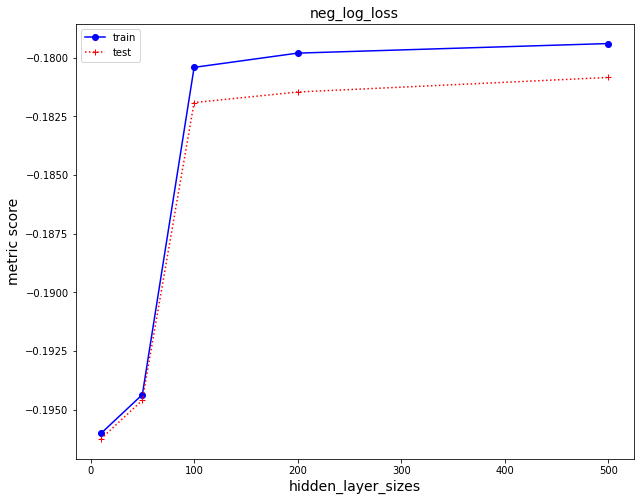

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


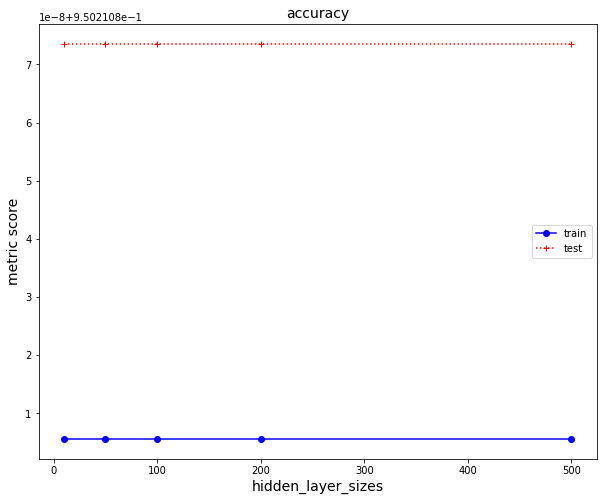

mean fit time: [0.44694061 0.3814146  2.06072598 2.61317301 3.64567504]


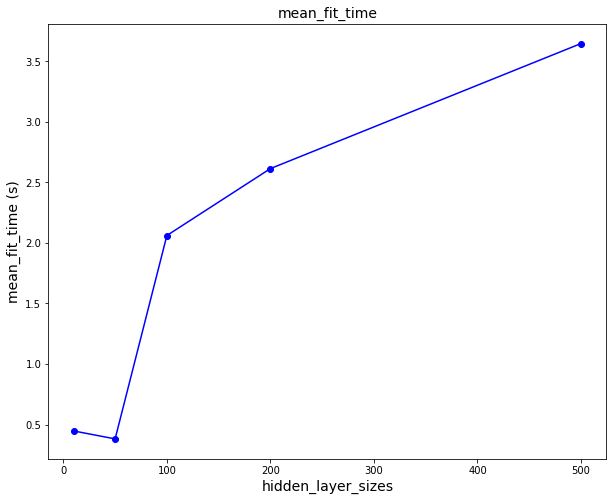

In [42]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### GRP+NN

train roc_auc score: [0.8119325  0.84807076 0.86717004 0.90012765 0.91590715]
test roc_auc score: [0.77233164 0.77202646 0.77641275 0.76949038 0.7554421 ]


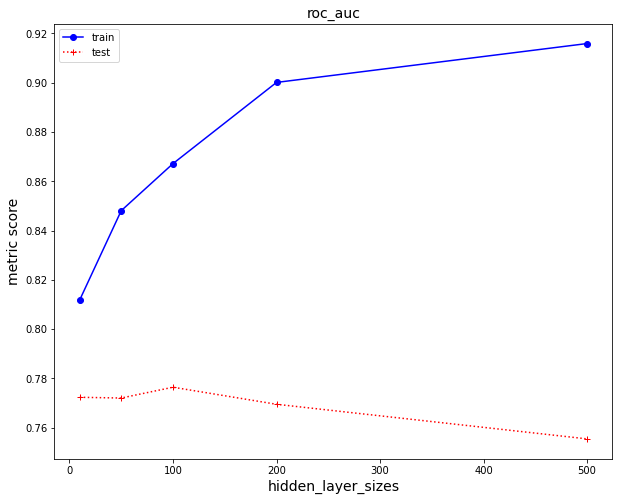

train neg_log_loss score: [-0.16726017 -0.1556895  -0.14898053 -0.13506078 -0.12716155]
test neg_log_loss score: [-0.1769541  -0.17890329 -0.17961194 -0.18727528 -0.19701749]


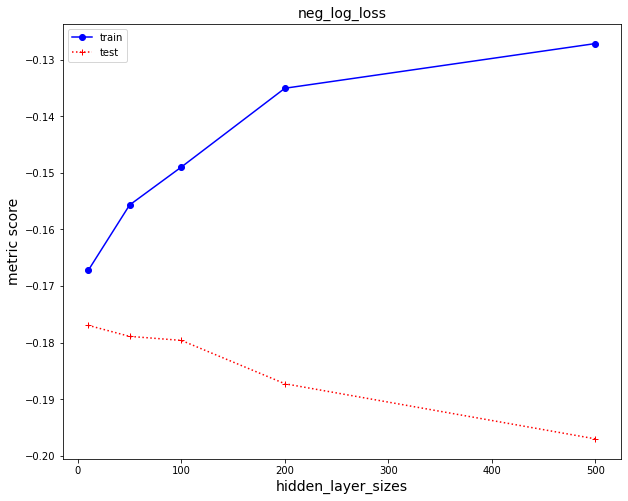

train accuracy score: [0.95041158 0.95071273 0.95151574 0.95312186 0.95512946]
test accuracy score: [0.94980947 0.94900626 0.94780144 0.945593   0.94238217]


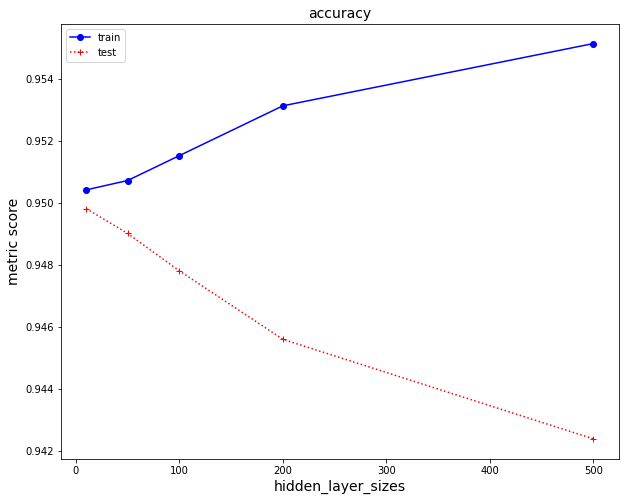

mean fit time: [ 1.43587828  2.55921454  3.64666896  8.12417083 14.41707973]


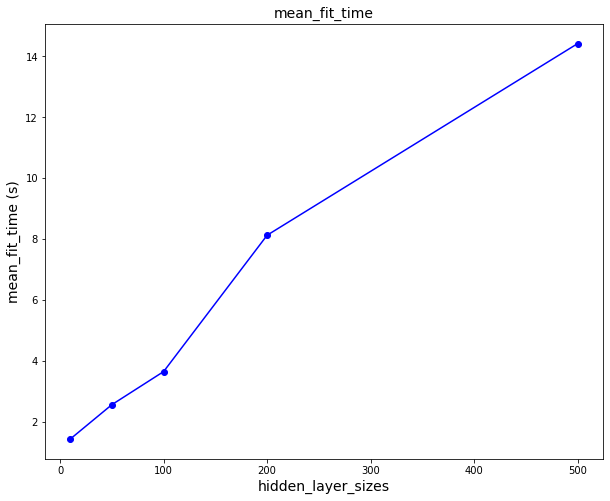

In [43]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### SVD + NN

train roc_auc score: [0.68948875 0.69197333 0.69251754 0.69290302 0.69361207]
test roc_auc score: [0.68610015 0.68491951 0.68381753 0.684774   0.68484678]


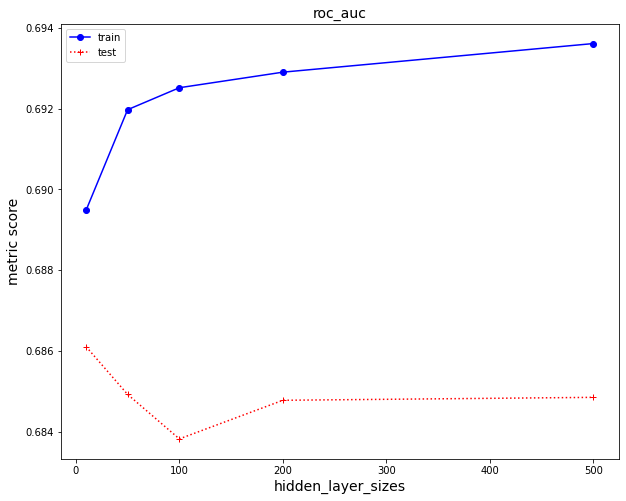

train neg_log_loss score: [-0.18670665 -0.18568568 -0.18551207 -0.18536299 -0.18526757]
test neg_log_loss score: [-0.18751184 -0.18700524 -0.18699957 -0.18677422 -0.18681323]


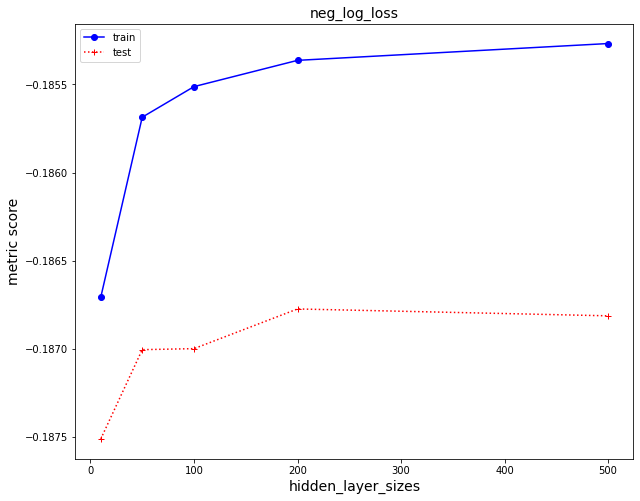

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


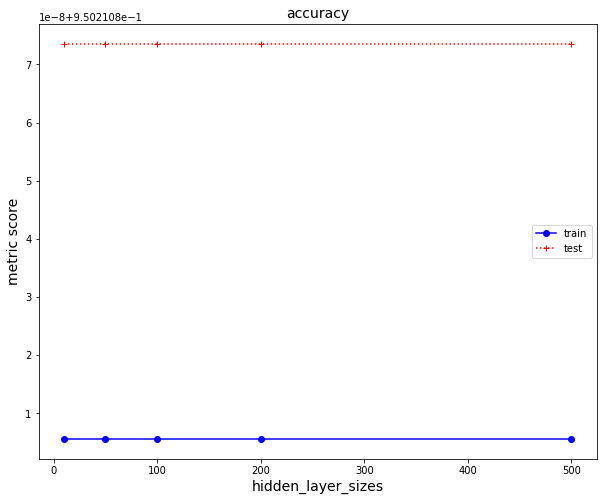

mean fit time: [0.76610403 0.66432519 0.72167802 0.8681797  1.49138556]


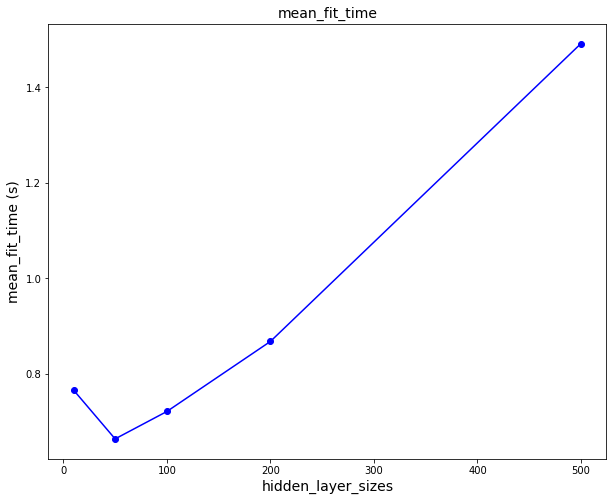

In [44]:
X0 = TruncatedSVD(2).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

train roc_auc score: [0.78886887 0.8142833  0.83243771 0.84579578 0.86104973]
test roc_auc score: [0.75884019 0.76250486 0.75638167 0.75846087 0.75687514]


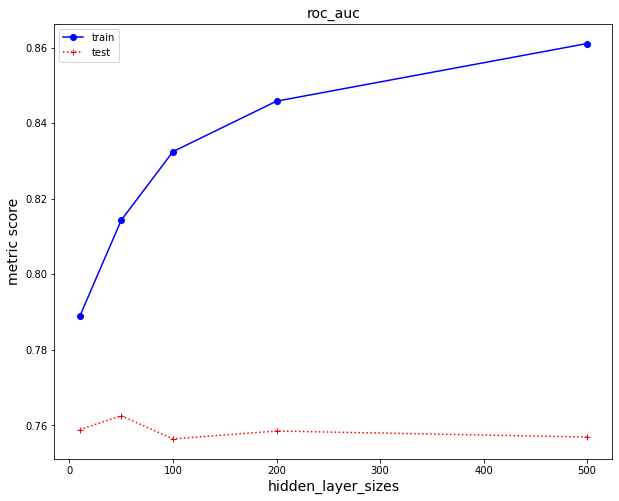

train neg_log_loss score: [-0.17137671 -0.1653411  -0.16025736 -0.15601684 -0.15130282]
test neg_log_loss score: [-0.17829961 -0.17885205 -0.18110459 -0.18344207 -0.18598876]


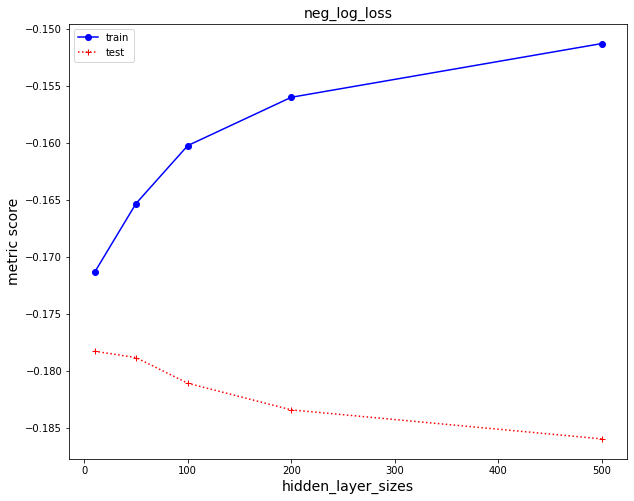

train accuracy score: [0.95021081 0.95051195 0.9509637  0.95136521 0.95166634]
test accuracy score: [0.95021087 0.94980927 0.94960846 0.95001007 0.95001007]


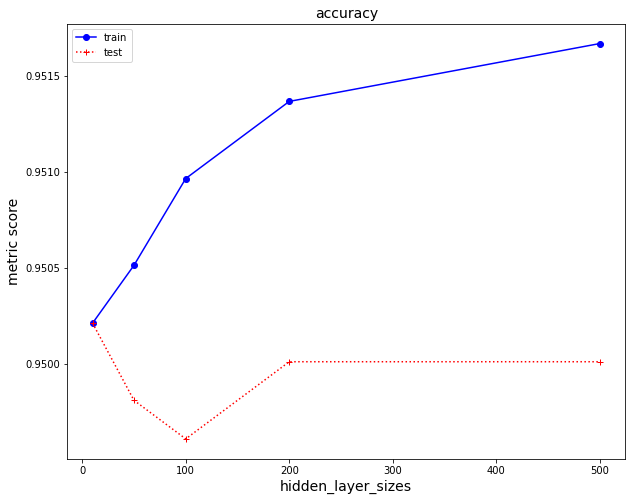

mean fit time: [0.91157269 1.47903767 2.71453109 4.24313226 8.45864897]


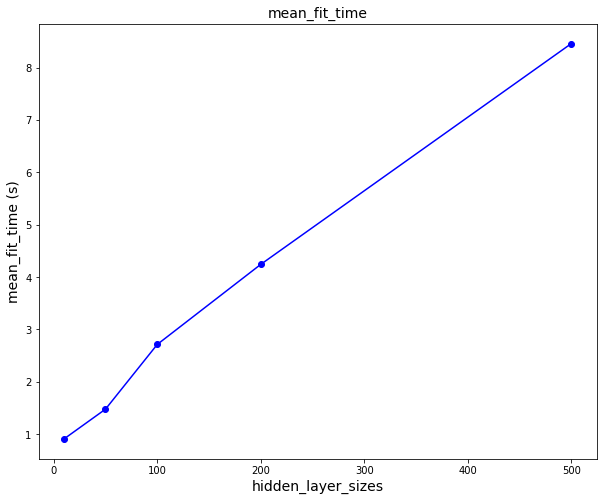

In [45]:
X0 = TruncatedSVD(8).fit_transform(X)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

## dr + cluster + NN

### pca + k-means + nn

train roc_auc score: [0.75063639 0.76531692 0.76601553 0.76767278 0.77608274]
test roc_auc score: [0.74952285 0.75706084 0.7585714  0.75897901 0.76104706]


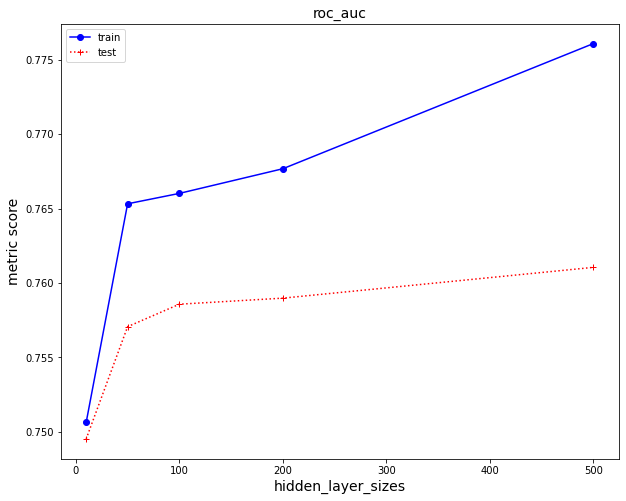

train neg_log_loss score: [-0.17947949 -0.17557761 -0.17537469 -0.17496309 -0.17350861]
test neg_log_loss score: [-0.18070843 -0.17857892 -0.17773817 -0.17766442 -0.17792701]


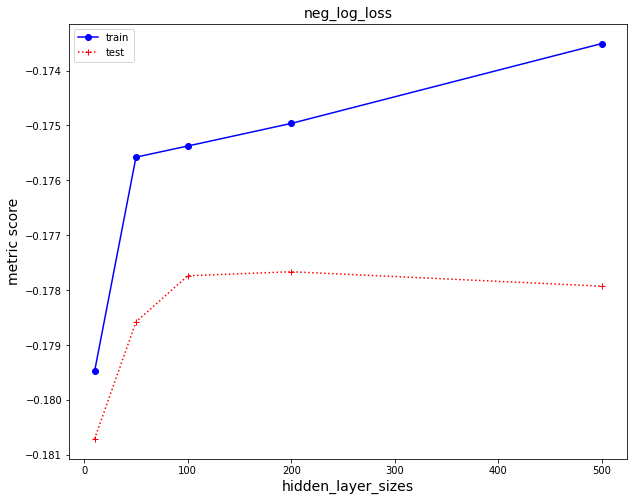

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


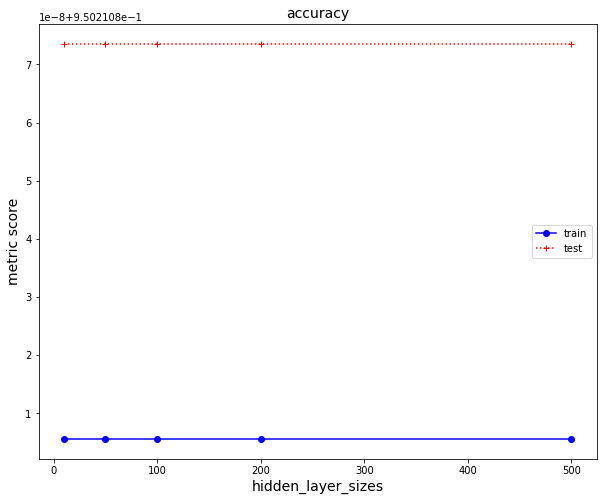

mean fit time: [0.6452435  0.79538746 0.87670813 1.28086848 3.39207253]


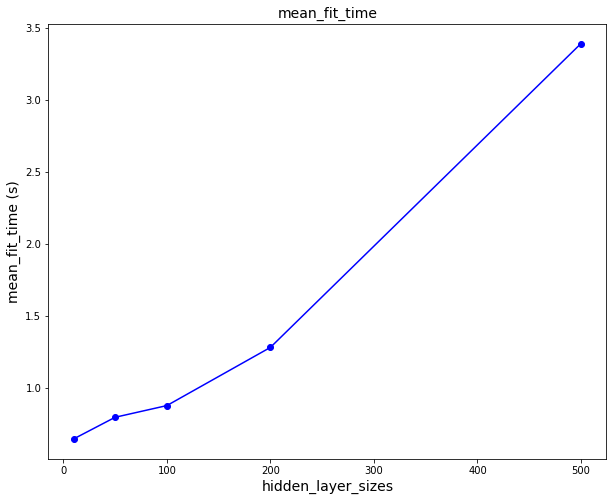

In [46]:
X0 = PCA(2).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

train roc_auc score: [0.78752224 0.8616525  0.87155353 0.8801474  0.88686028]
test roc_auc score: [0.7582213  0.77898222 0.77345474 0.77193778 0.76212866]


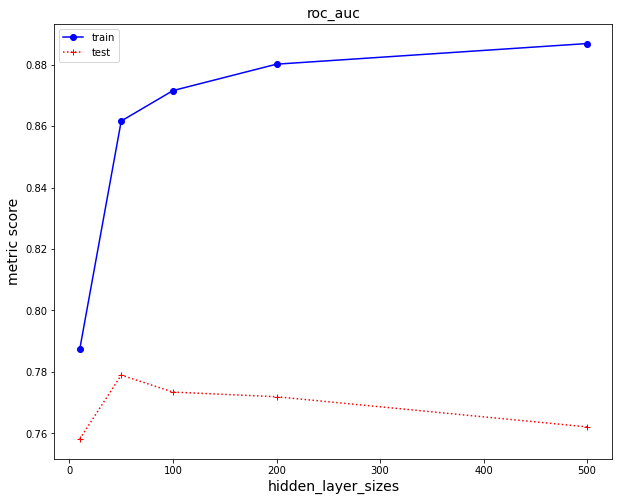

train neg_log_loss score: [-0.1718857  -0.15099513 -0.14723536 -0.14394957 -0.1409571 ]
test neg_log_loss score: [-0.17922107 -0.17781526 -0.18213518 -0.18517103 -0.19135949]


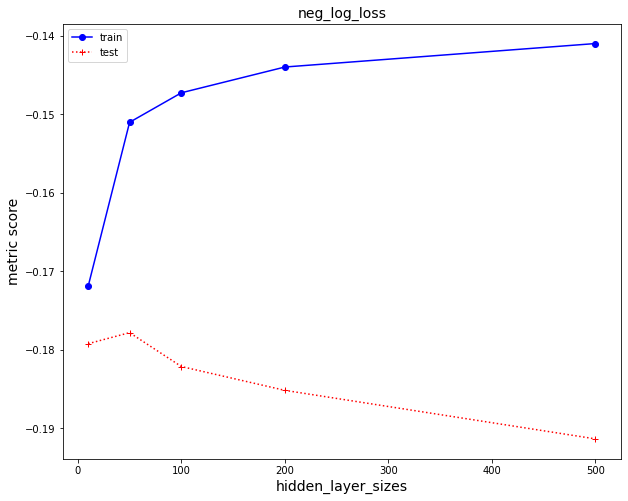

train accuracy score: [0.95021081 0.9518169  0.95171651 0.95246938 0.95267013]
test accuracy score: [0.95021087 0.94940766 0.94880525 0.94900585 0.94780184]


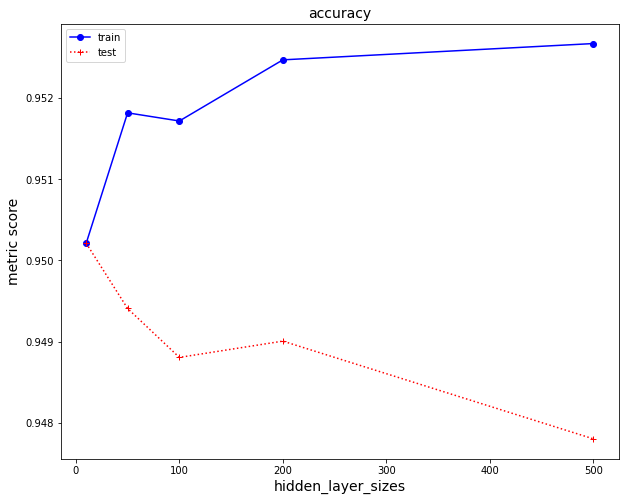

mean fit time: [0.76455598 2.74529705 3.52831726 5.11893177 9.07786708]


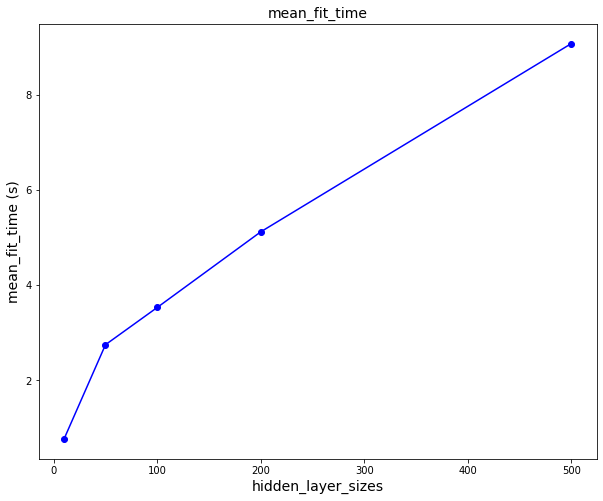

In [47]:
X0 = PCA(8).fit_transform(X)
clf = KMeans(n_clusters=6, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### pca + em + nn

train roc_auc score: [0.74233658 0.7694308  0.77435618 0.77705981 0.77693874]
test roc_auc score: [0.73435182 0.76272519 0.76650863 0.76843506 0.76861138]


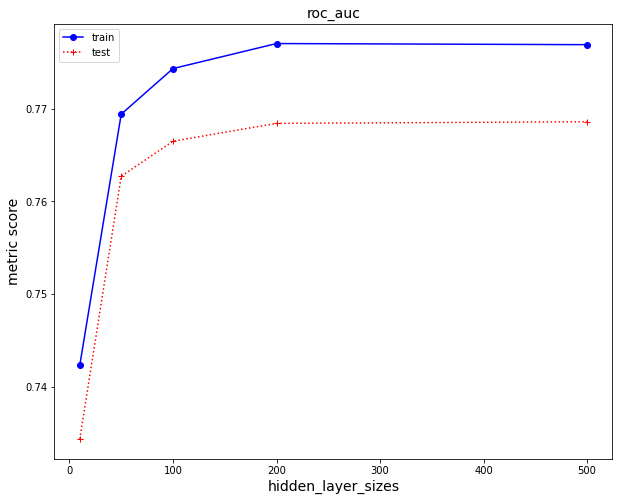

train neg_log_loss score: [-0.17988883 -0.17462652 -0.17388229 -0.17346159 -0.17352293]
test neg_log_loss score: [-0.18191492 -0.17699146 -0.17709709 -0.17698696 -0.1764524 ]


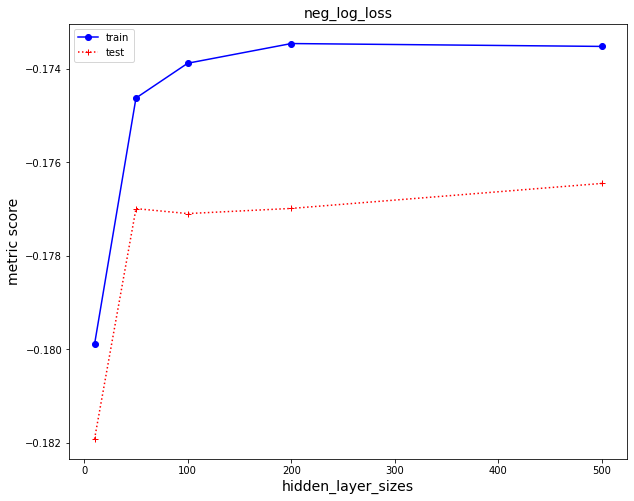

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


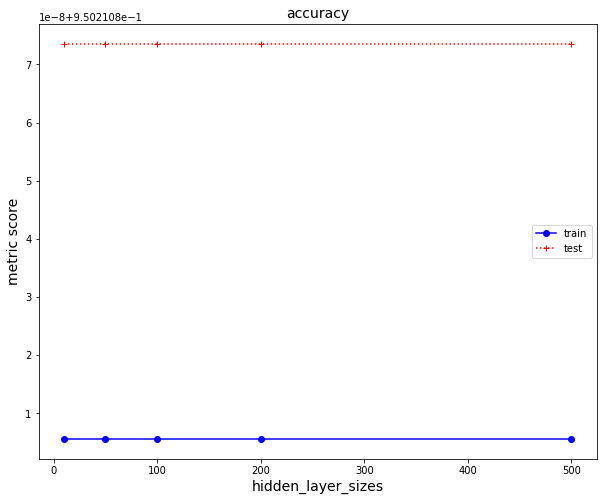

mean fit time: [0.47626419 0.85133157 0.92458696 1.34054208 2.13217936]


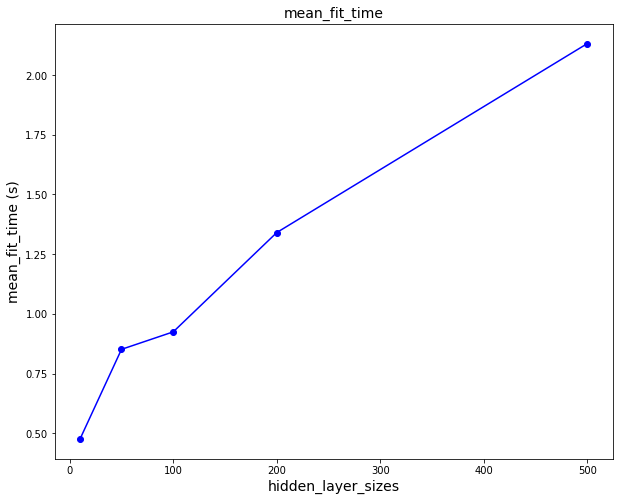

In [48]:
X0 = PCA(2).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### ica + kmeans+nn

train roc_auc score: [0.70307011 0.71643781 0.74851857 0.75067344 0.75351007]
test roc_auc score: [0.69156123 0.70839127 0.73904403 0.74211659 0.74598975]


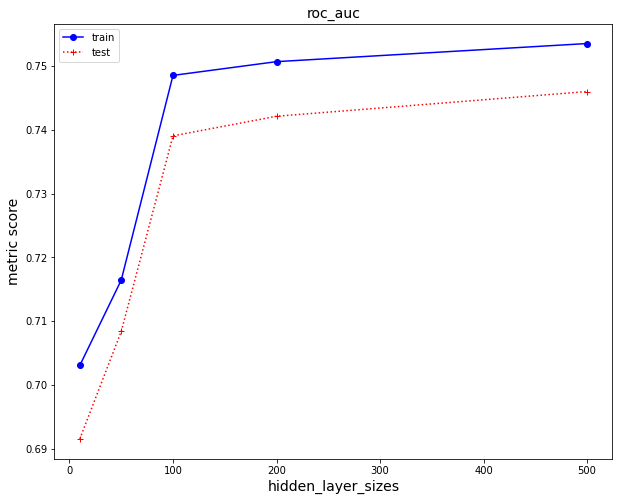

train neg_log_loss score: [-0.1955092  -0.18936458 -0.17996908 -0.17955469 -0.17948015]
test neg_log_loss score: [-0.19565848 -0.18935568 -0.18145951 -0.18081911 -0.18096979]


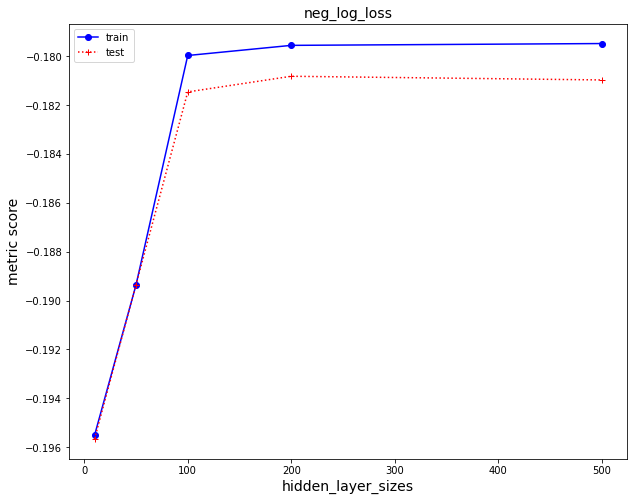

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


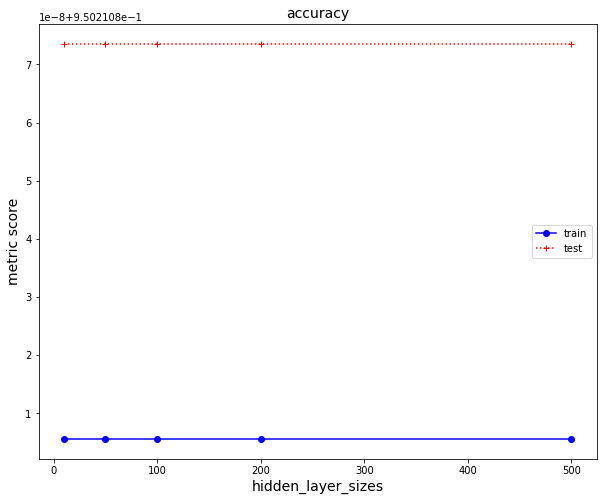

mean fit time: [0.42176757 0.88839669 2.08166914 2.39174824 3.57909126]


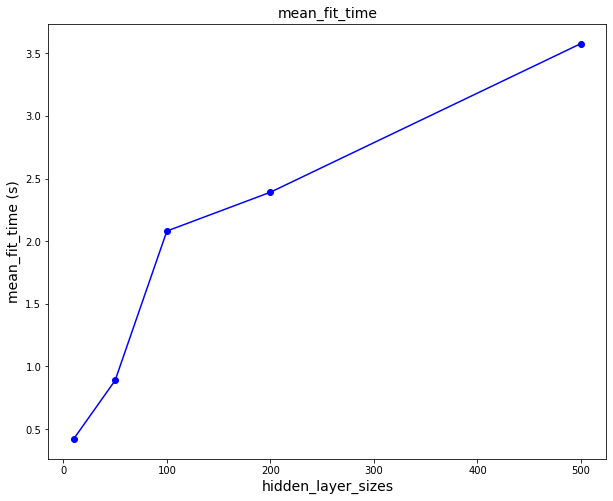

In [49]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### ica + em + nn

train roc_auc score: [0.67476461 0.73312115 0.74597237 0.75111551 0.75400846]
test roc_auc score: [0.65349535 0.71784324 0.73609991 0.74284896 0.74565504]


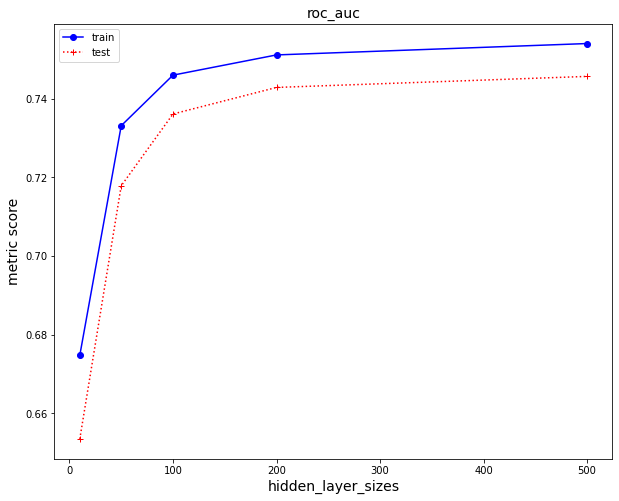

train neg_log_loss score: [-0.19571991 -0.18555636 -0.18038145 -0.17963376 -0.17919638]
test neg_log_loss score: [-0.19603987 -0.18693998 -0.18188104 -0.18102952 -0.18083068]


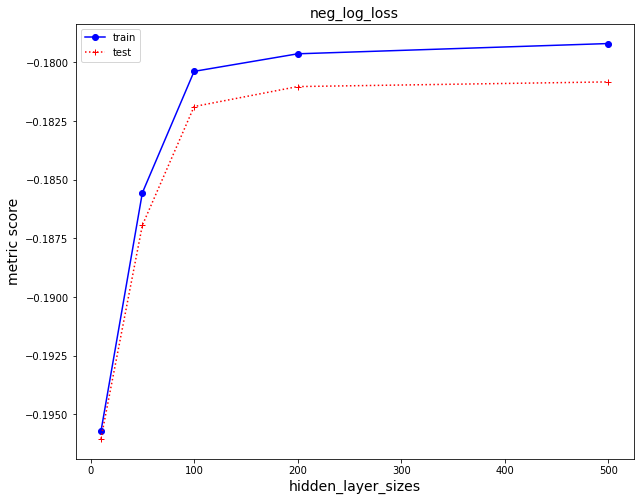

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


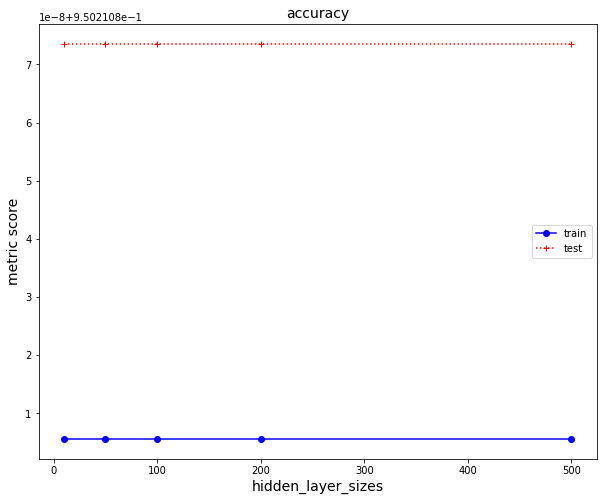

mean fit time: [0.48718758 1.34391141 2.03107944 2.36947312 3.68707523]


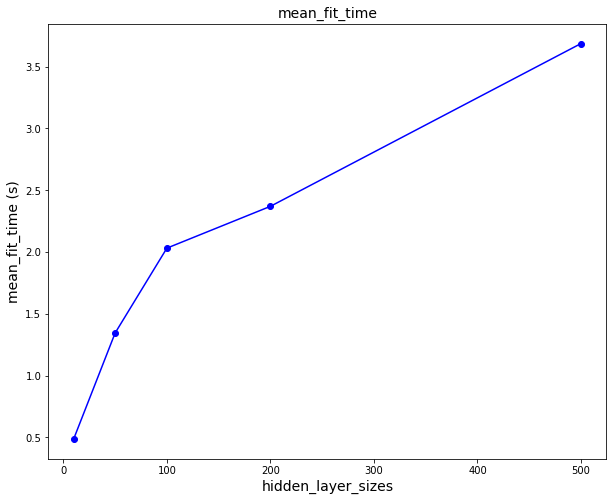

In [50]:
X0 = FastICA(n_components = 4, random_state=rand_state).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### grp + kmeans+nn

train roc_auc score: [0.81670549 0.85840348 0.87406711 0.90074257 0.91421842]
test roc_auc score: [0.76449426 0.77216023 0.77218521 0.76876146 0.75490947]


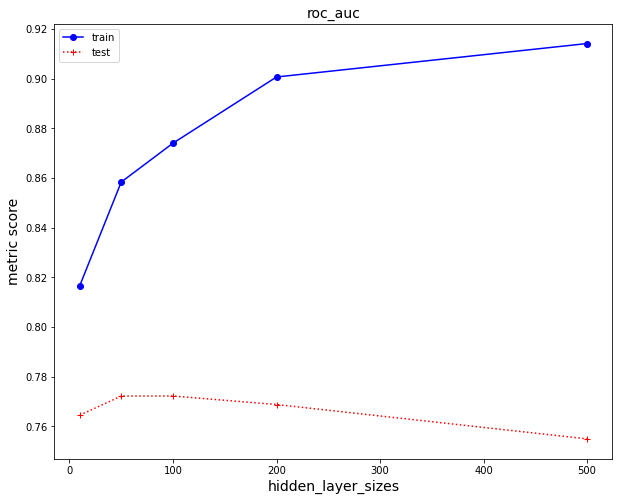

train neg_log_loss score: [-0.16628098 -0.15255693 -0.14658725 -0.1344131  -0.12753605]
test neg_log_loss score: [-0.17845506 -0.18080346 -0.18136201 -0.18891896 -0.19765657]


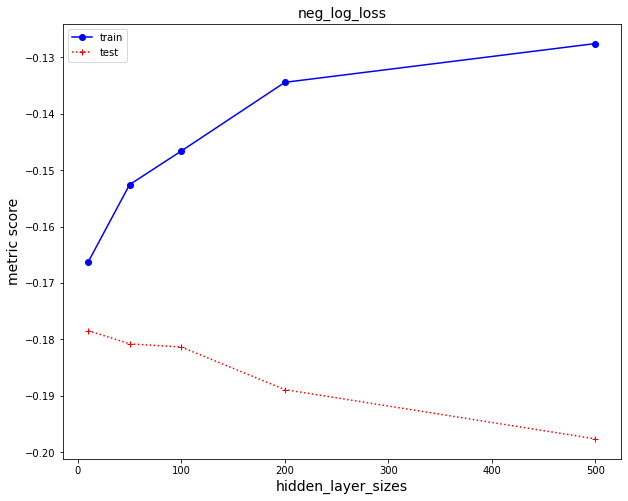

train accuracy score: [0.95041157 0.95091344 0.95146555 0.9531721  0.95512954]
test accuracy score: [0.94940786 0.94800264 0.94840385 0.9449918  0.94338558]


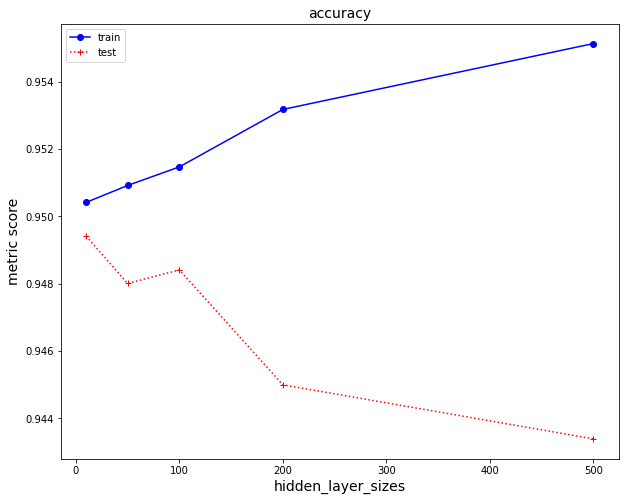

mean fit time: [ 1.50175233  3.25381241  3.81755171  7.70817399 12.35822148]


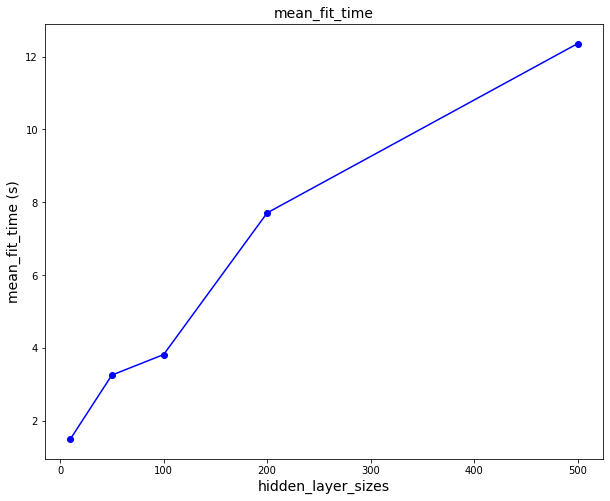

In [51]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### grp + em + nn

train roc_auc score: [0.81898497 0.85111765 0.8701598  0.89513461 0.91998501]
test roc_auc score: [0.77569304 0.77552993 0.7737807  0.7719931  0.7492661 ]


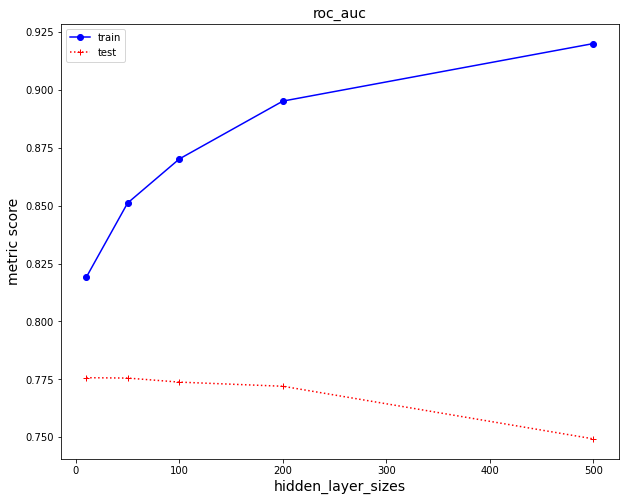

train neg_log_loss score: [-0.16518793 -0.15494019 -0.14803529 -0.13741747 -0.12430691]
test neg_log_loss score: [-0.17603585 -0.17818537 -0.18173994 -0.1868416  -0.20096677]


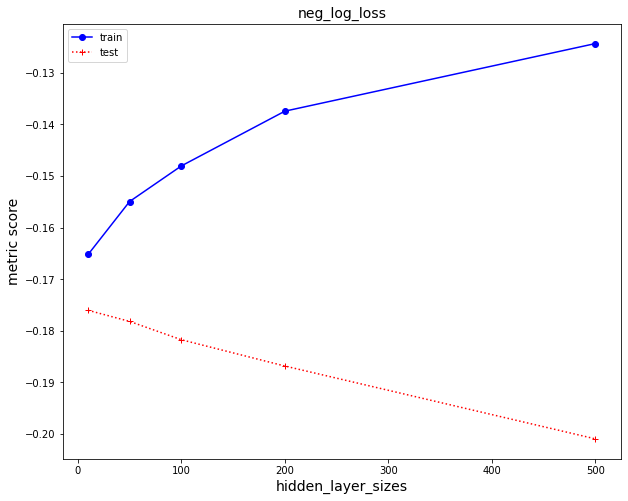

train accuracy score: [0.95041156 0.95076291 0.95116444 0.95302163 0.95598288]
test accuracy score: [0.94980947 0.94780144 0.94739983 0.94519301 0.94238237]


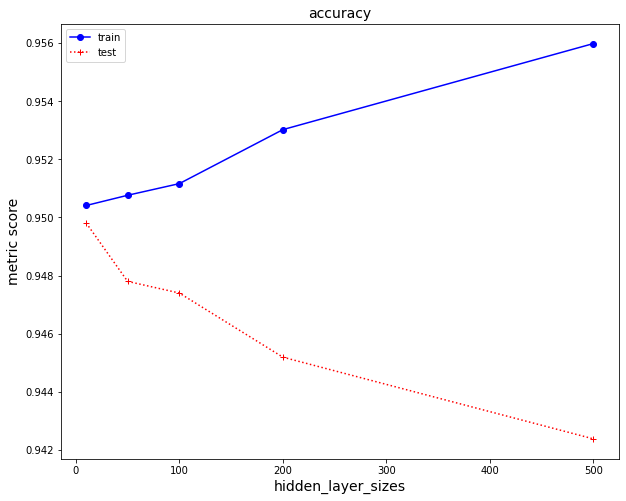

mean fit time: [ 1.4150064   2.31050692  3.83990221  6.57589159 13.72546787]


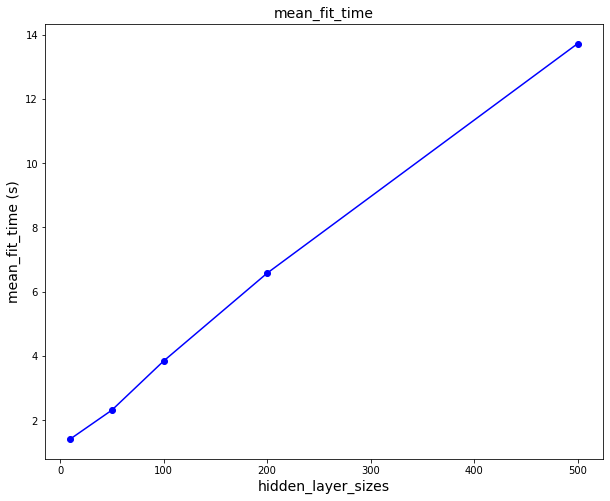

In [52]:
X0 = GaussianRandomProjection(n_components = 8, random_state=rand_state).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### svd + kmeans+nn

train roc_auc score: [0.68482796 0.69128719 0.69256211 0.69363284 0.69439238]
test roc_auc score: [0.68231998 0.68216918 0.6847822  0.68451492 0.68503159]


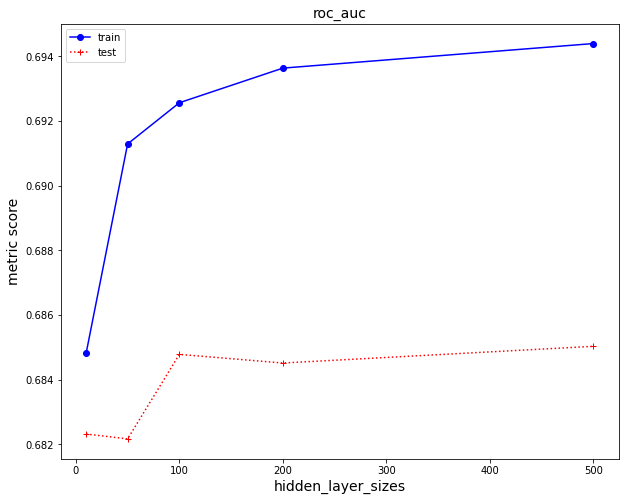

train neg_log_loss score: [-0.18732236 -0.18577512 -0.18546124 -0.18518245 -0.18532147]
test neg_log_loss score: [-0.18829757 -0.18710912 -0.18682459 -0.18680527 -0.18698894]


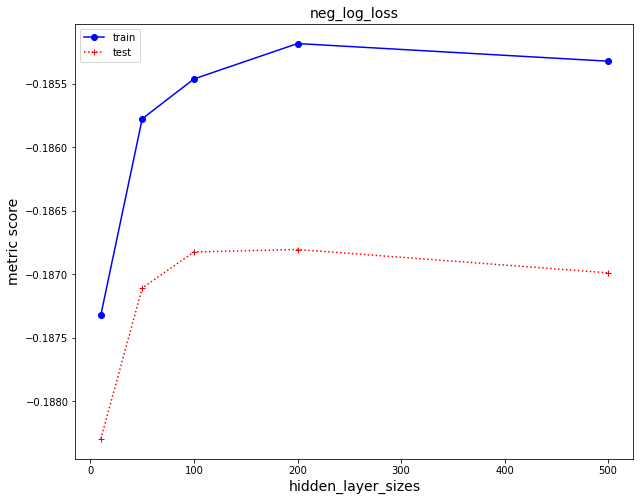

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


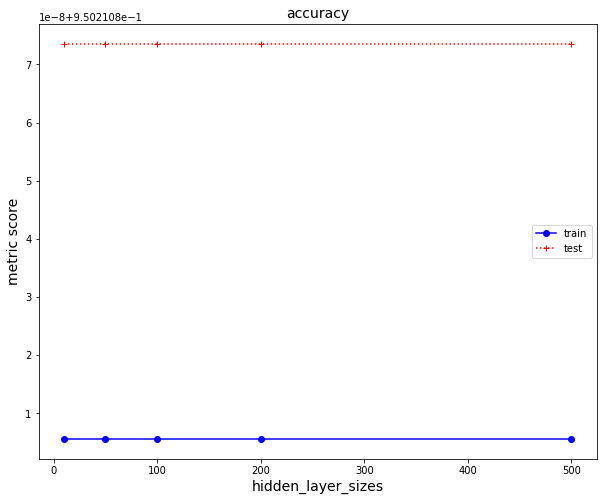

mean fit time: [0.7366199  0.76770067 0.78761048 0.97586555 1.60463176]


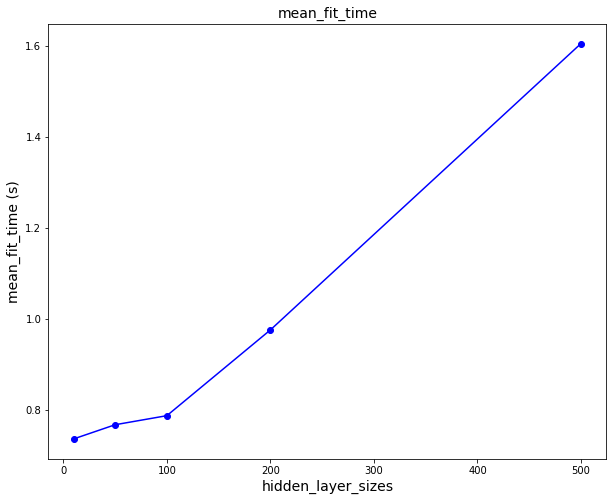

In [53]:
X0 = TruncatedSVD(2).fit_transform(X)
clf = KMeans(n_clusters=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.labels_
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

### svd + em + nn

train roc_auc score: [0.67964363 0.68869453 0.69586381 0.69782287 0.70226788]
test roc_auc score: [0.67237464 0.67534476 0.68053214 0.68322472 0.68305948]


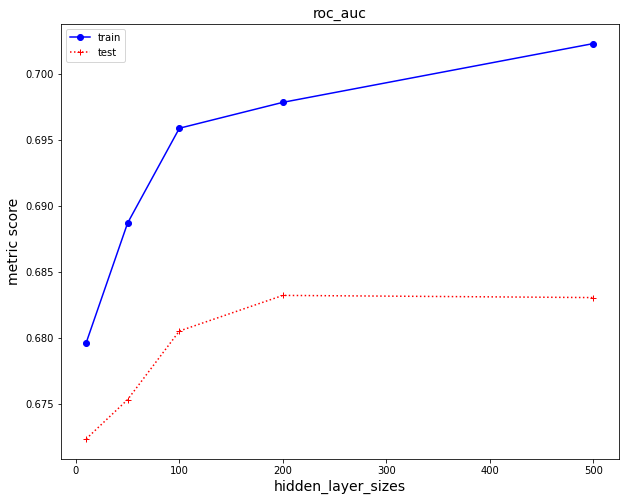

train neg_log_loss score: [-0.18770517 -0.18580217 -0.18495428 -0.18476249 -0.18417924]
test neg_log_loss score: [-0.18921555 -0.18824415 -0.18716543 -0.18691934 -0.18678772]


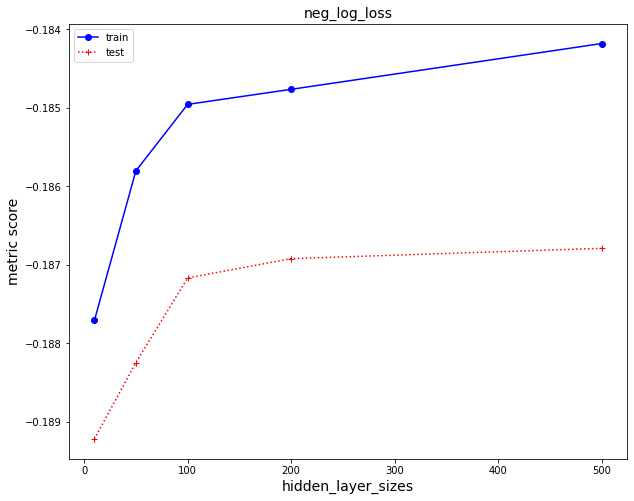

train accuracy score: [0.95021081 0.95021081 0.95021081 0.95021081 0.95021081]
test accuracy score: [0.95021087 0.95021087 0.95021087 0.95021087 0.95021087]


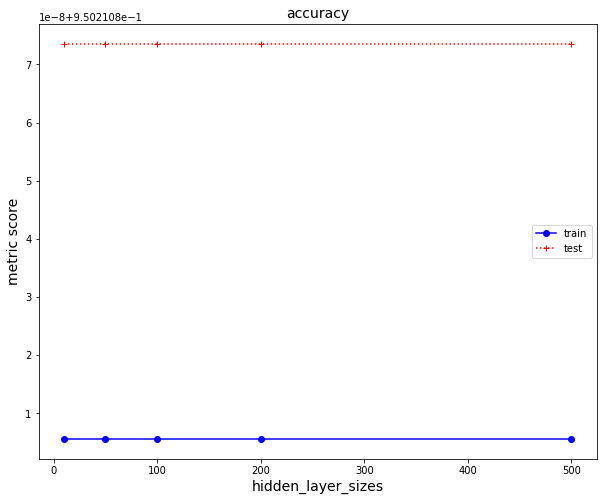

mean fit time: [0.93012071 0.7224102  1.00967693 1.21488671 2.42372985]


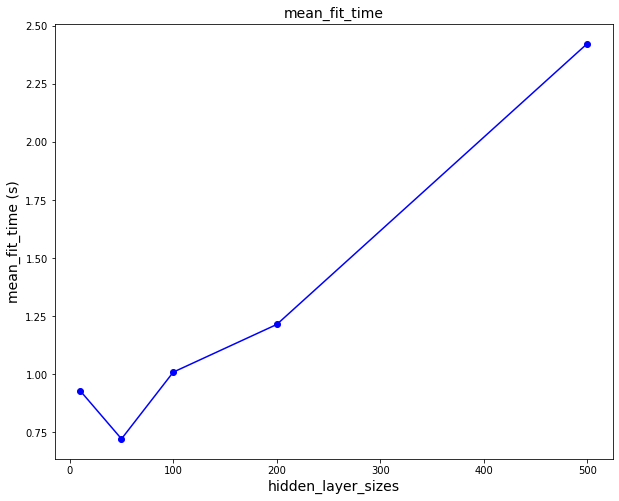

In [54]:
X0 = TruncatedSVD(2).fit_transform(X)
clf = GaussianMixture(n_components=2, random_state=rand_state)
clf.fit(X0)
X0 = pd.DataFrame(X0)
X0['cluster_label'] = clf.predict(X0)
X0 = pd.get_dummies(X0, columns = ['cluster_label']
                    , prefix = 'cluster_label', drop_first = True)
data0 = pd.concat([pd.DataFrame(X0), y], axis=1)
train_test(data0, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])

# NN

train roc_auc score: [0.85295984 0.8859567  0.91285888 0.93489367 0.96183779]
test roc_auc score: [0.82549498 0.81265991 0.78635269 0.76870589 0.73936738]


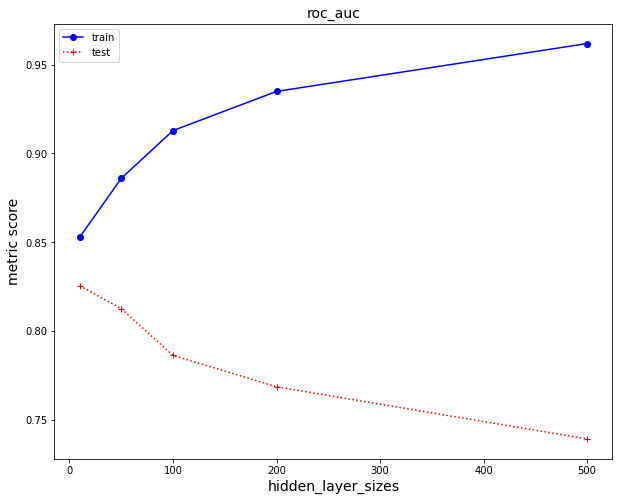

train neg_log_loss score: [-0.15459951 -0.14038939 -0.12739344 -0.1148955  -0.09563842]
test neg_log_loss score: [-0.16491707 -0.17528662 -0.18783593 -0.20352823 -0.23812322]


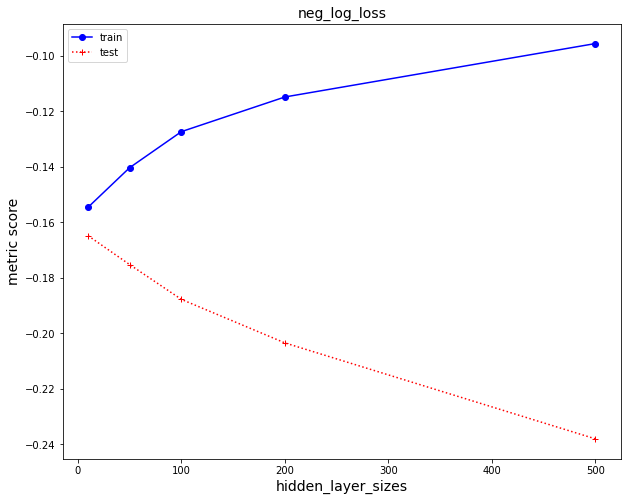

train accuracy score: [0.95081309 0.95246935 0.95467778 0.95849219 0.96592053]
test accuracy score: [0.95001007 0.94760023 0.9451912  0.93976971 0.93234261]


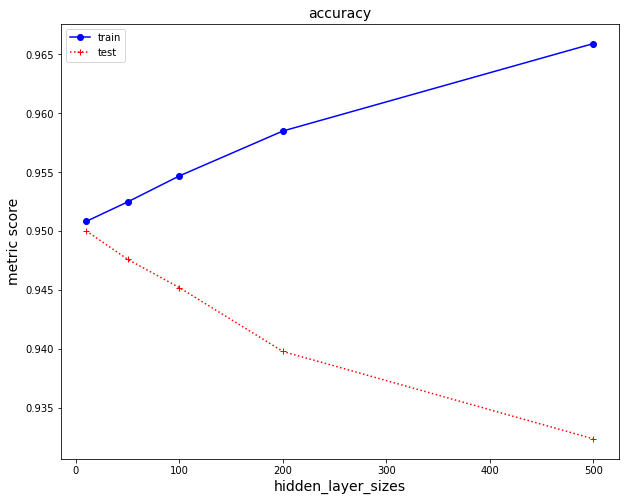

mean fit time: [ 1.44815307  2.50408673  4.58315587  7.92752328 18.6049232 ]


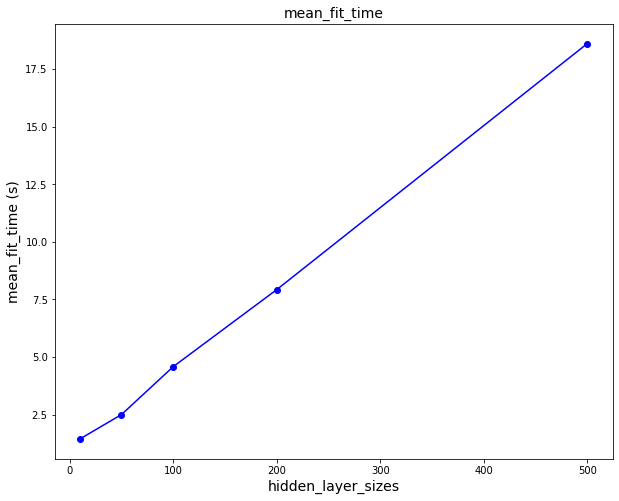

In [55]:
train_test(data, MLP(), {'hidden_layer_sizes':[10,50,100,200,500], 'max_iter':[1000]},metric = ['roc_auc','neg_log_loss','accuracy'])